# Problem Set 2
### Civic Analytics
Energy use in buildings accounts for approximately 79% of all of New York City’s energy consumption
and carbon emissions. In an effort to improve its sustainability and efficiency, the City adopted an
ambitious goal of reducing carbon emissions by 80% by the year 2050. The New York City Mayor’s
Office of Sustainability (MOS) is responsible for implementing this plan, which calls for major reductions
in building energy use (The City of New York, 2016). One significant analytical challenge is to develop a
robust method for peer comparison and benchmarking of buildings. This is necessary to understand
relative building energy performance, given the specific characteristics of a building, and to design
regulations that require buildings to meet a certain energy performance standard. Another concern
revolves around environmental justice and the impact of building energy use and emissions on local
communities. The question is whether low-income communities disproportionately bear the burden of
inefficient buildings and possible negative effects on health.

### Q: How can we develop a metric for understanding energy performance and peer building comparison that accounts for the differences in building and occupancy characteristics that impact consumption?

1. Clean (including outliers) and merge the Local Law 84 data, PLUTO data, and Census data (and
other datasets as needed)
2. Provide descriptive statistics for the integrated dataset of key variables in your analysis
3. Create an appropriate model to test your hypothesis
4. Develop a visualization (map) for your results, as well as plots, graphs, and model output
5. Discuss your findings in terms of how they address the respective question you set out to
answer. Discuss the limitations of your approach and justify any assumptions used in your
analysis.

___

# Data cleaning
Source code: Provided by Prof Kontokosta, ipython notebook LabSession_Nov3v2

In [21]:
import pandas as pd
import numpy as np
import sys
import operator
from scipy import stats
import statsmodels.formula.api as smf
import requests
from IPython.display import HTML
import matplotlib.pylab as plt
import warnings
# import geopandas as gpd
# from fiona.crs import from_epsg

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/sebscho/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [22]:
# Formatting
# These are the "Tableau 20" colors as RGB.
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
 
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)

plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['font.serif'] = 'Arial'
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['figure.frameon'] = False
plt.rcParams['axes.prop_cycle'] = cycler('color',tableau20)
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.fontsize'] = 14

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [23]:
# read in LL84 data
link1 = 'http://www.nyc.gov/html/gbee/downloads/excel/nyc_benchmarking_disclosure_data_reported_in_2016.xlsx'

In [24]:
#os.system('curl -o ll84_2016.xslx %s'%(link1))

In [25]:
# bringing in the ll84 data
ll84 = pd.read_excel(r'http://www.nyc.gov/html/gbee/downloads/excel/nyc_benchmarking_disclosure_data_reported_in_2016.xlsx')

In [26]:
ll84.to_csv(r'll84_2016.csv', encoding='utf-8')

In [27]:
df = pd.read_csv(r'll84_2016.csv')
df.head(1)

,Unnamed: 0,Record Number,Order,"NYC Borough, Block and Lot (BBL)",Co-reported BBL Status,BBLs Co-reported,Reported NYC Building Identification Numbers (BINs),Property Name,Parent Property Id,Parent Property Name,Street Number,Street Name,Zip Code,Borough,DOF Benchmarking Submission Status,Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type,Largest Property Use Type - Gross Floor Area (ft²),2nd Largest Property Use Type,2nd Largest Property Use - Gross Floor Area (ft²),3rd Largest Property Use Type,3rd Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings - Self-reported,Occupancy,Metered Areas (Energy),Metered Areas (Water),ENERGY STAR Score,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Source EUI (kBtu/ft²),Weather Normalized Source EUI (kBtu/ft²),Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),District Steam Use (kBtu),District Hot Water Use (kBtu),District Chilled Water Use (kBtu),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),DOF Property Floor Area (ft²),Property GFA - Self-reported (ft²),Water Use (All Water Sources) (kgal),Municipally Supplied Potable Water - Indoor Intensity (gal/ft²),Release Date,DEP Provided Water Use (kgal),Automatic Water Benchmarking Eligible,Reported Water Method
0,0,4113711.0,1,1.003360e+09,NaN,NaN,1088884,16 Bialystoker Place,Not Applicable: Standalone Property,Not Applicable: Standalone Property,15.0,BIALYSTOKER PLACE,10002.0,Manhattan,In Compliance,Multifamily Housing,Multifamily Housing,Multifamily Housing,98000.0,Not Available,Not Available,Not Available,Not Available,1982,1.0,100.0,Whole Building,Not Available,87.0,73.7,74.4,5.3,0.6,115.0,115.7,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,5463399.1,55261.4,1762214.1,516475.3,436.3,290.2,146.1,98052.0,98000.0,NaN,NaN,2016-04-13 11:08:48,NaN,NaN,NaN


In [28]:
# get rid of this column
del df['Unnamed: 0']

# make BBL ready for merging, other column names easier to work with
df.rename(columns={'NYC Borough, Block and Lot (BBL)': 'BBL', 'Total GHG Emissions (Metric Tons CO2e)':'ghg'}, inplace=True) 

# keep what we need
df = df[['BBL','Property Name','Zip Code','Borough','Primary Property Type - Self Selected','Largest Property Use Type - Gross Floor Area (ft²)', 'Order', 'Year Built', 'Number of Buildings - Self-reported', 'Occupancy','ENERGY STAR Score', 'Site EUI (kBtu/ft²)',
        'Weather Normalized Site EUI (kBtu/ft²)', 'ghg','DOF Property Floor Area (ft²)', 'Property GFA - Self-reported (ft²)']]

# cleaning up so it's easier to work with
cols = df.columns.str.replace('²', '_2') ### \xc2\xb2 for py2
df.columns = cols
df.columns

Index(['BBL', 'Property Name', 'Zip Code', 'Borough',
       'Primary Property Type - Self Selected',
       'Largest Property Use Type - Gross Floor Area (ft_2)', 'Order',
       'Year Built', 'Number of Buildings - Self-reported', 'Occupancy',
       'ENERGY STAR Score', 'Site EUI (kBtu/ft_2)',
       'Weather Normalized Site EUI (kBtu/ft_2)', 'ghg',
       'DOF Property Floor Area (ft_2)',
       'Property GFA - Self-reported (ft_2)'],
      dtype='object')

In [29]:
# exploration
mydict = dict(zip(df.groupby('Primary Property Type - Self Selected')['Order'].count().index,
                  df.groupby('Primary Property Type - Self Selected')['Order'].count().values))

# show the top 5 mostly encountered building typologies
from operator import itemgetter
sorted(mydict.items(), key=itemgetter(1), reverse=True)[:6]

[('Multifamily Housing', 8699),
 ('Office', 1233),
 ('See Primary BBL', 447),
 ('Hotel', 236),
 ('Non-Refrigerated Warehouse', 177),
 ('Other', 129)]

In [30]:
# looking only at multifamily housing units
df = df[df['Primary Property Type - Self Selected'] == 'Multifamily Housing']


In [31]:
# making second dataframe for the Bronx, multi family housing
df_bx = df[df['Borough'] == 'Bronx']

In [32]:
# rename for cleaning
df.rename(columns={'Site EUI (kBtu/ft_2)': 'eui'}, inplace=True) 
df_bx.rename(columns={'Site EUI (kBtu/ft_2)': 'eui'}, inplace=True) 


/Users/sebscho/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [59]:
def clean(df):
    """Takes the logarithm of EUI for a particular building type and filters out
    examples that fall outside the threshold of two standard deviations.
    
    Returns outlier-free dataframe."""
    
    df = df[(df.log_ghg<np.mean(df.log_ghg)+2*np.std(df.log_ghg))&(df.log_ghg>np.mean(df.log_ghg)-2*np.std(df.ghg))]
    return df

In [61]:
df_bx['log_ghg'] = np.log10(df_bx.ghg)
df_bx = clean(df_bx)
print ('Examples after cleaning GHG (BRONX):', len(df_bx))

Examples after cleaning GHG (BRONX): 1274


In [89]:
# bringing in PLUTO data
bxpluto = pd.read_csv('BX.csv')

# keeping only what we need
bxpluto = bxpluto[['BBL','Borough','Block','Block','ZipCode','HealthArea','Address','LandUse','OwnerType','LotArea','AreaSource','NumBldgs','NumFloors','UnitsRes','UnitsTotal','BldgFront','YearBuilt','XCoord','YCoord']]

# merge clean df_bx with pluto data
bx = pd.merge(df_bx,bxpluto, on='BBL', how='inner')
bx.rename(columns={'Primary Property Type - Self Selected': 'property_type', 'Total GHG Emissions (Metric Tons CO2e)':'ghg', 'Zip Code': 'Zip', 'Largest Property Use Type - Gross Floor Area (ft_2)': 'floor_area', 'Year Built': 'year_built', 'Property GFA - Self-reported (ft_2)': 'prop_gfa'}, inplace=True) 


/Users/sebscho/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (18,19,21,22,63,64,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [93]:
# only keeping landuse codes for Multi-family elevator buildings that we have LL84 data for
bx = bx[~bx['LandUse'].isin(['11.0', '5.0', '8.0', '2.0', '3.0'])]

# getting rid of floor_area outliers
bx_floor = (bx.floor_area>0) & (bx.floor_area<250000)
bx = bx[bx_floor]

In [94]:
# Booyah!
bx.head()

,BBL,Property Name,Zip,Borough_x,property_type,floor_area,Order,year_built,Number of Buildings - Self-reported,Occupancy,ENERGY STAR Score,eui,Weather Normalized Site EUI (kBtu/ft_2),ghg,DOF Property Floor Area (ft_2),prop_gfa,wn_eui,log_wn_eui,log_ghg,Borough_y,Block,Block,ZipCode,HealthArea,Address,LandUse,OwnerType,LotArea,AreaSource,NumBldgs,NumFloors,UnitsRes,UnitsTotal,BldgFront,YearBuilt,XCoord,YCoord
2,2.022820e+09,138 SHARP REALTY LLC,10454.0,Bronx,Multifamily Housing,145936.0,5360,1910,1.0,100.0,68.0,71.0,71.0,648.3,145936.0,145936.0,71.0,1.851258,2.811776,BX,2282,2282,10454.0,4500.0,430 EAST 138 STREET,4.0,P,30000,2,4,7.0,148,155,150.00,1932,1005895.0,233728.0
5,2.022920e+09,CC - 454-464 East 148th Street,10455.0,Bronx,Multifamily Housing,92998.0,5367,1887,1.0,100.0,51.0,85.5,86.3,467.3,91998.0,92998.0,86.3,1.936011,2.669596,BX,2292,2292,10455.0,4400.0,454 EAST 148 STREET,4.0,P,21485,2,2,5.0,79,81,115.00,1887,1007517.0,235934.0
10,2.023480e+09,151st and Walton LLC,10451.0,Bronx,Multifamily Housing,112400.0,5397,1930,1.0,100.0,22.0,115.1,114.9,981.2,115500.0,115500.0,114.9,2.060320,2.991758,BX,2348,2348,10451.0,3800.0,175 EAST 151 STREET,4.0,NaN,29730,2,1,6.0,98,103,244.00,1930,1004434.0,238389.0
12,2.023640e+09,CC - 3100 3rd Avenue,10451.0,Bronx,Multifamily Housing,110651.0,5407,2009,1.0,100.0,82.0,67.1,66.9,456.7,119770.0,110651.0,66.9,1.825426,2.659631,BX,2364,2364,10451.0,4000.0,495 EAST 158 STREET,4.0,P,7613,2,1,8.0,107,110,169.00,2009,1008713.0,238614.0
13,2.023648e+09,Wavecrest - 3044 3rd Ave,10451.0,Bronx,Multifamily Housing,84301.0,5408,2006,1.0,100.0,61.0,66.7,67.0,343.9,79529.0,84301.0,67.0,1.826075,2.536432,BX,2364,2364,10455.0,4000.0,3044 3 AVENUE,4.0,NaN,14990,2,1,9.0,61,62,100.42,2006,1008458.0,238121.0


# Exploration, descriptive statistics

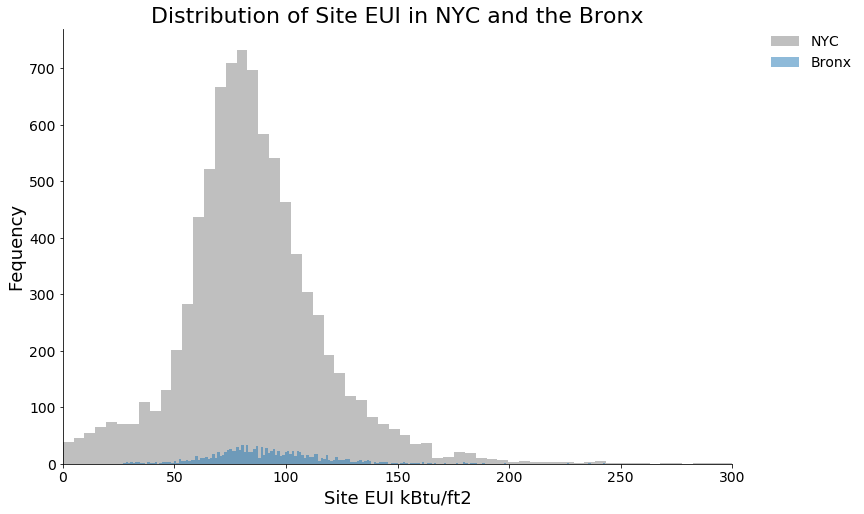

This shows the distribution of site EUI for NYC and for the Bronx. The distributions look noticeably different, but we can test to be sure


In [97]:
# This shows that the distribution of Site EUI in the Bronx as compared to the whole city
plt.hist(df['eui'][df['eui']<1000], bins=200, color = "Grey", label = "NYC", alpha=0.5)
plt.hist(df_bx['eui'][df_bx['eui']<1000], bins=200, label = "Bronx", alpha=0.5)
plt.title('Distribution of Site EUI in NYC and the Bronx')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Site EUI kBtu/ft2')
plt.xlim(0, 300)
plt.ylabel('Fequency')
plt.show()
print ('This shows the distribution of site EUI for NYC and for the Bronx. The distributions look noticeably different, but we can test to be sure')

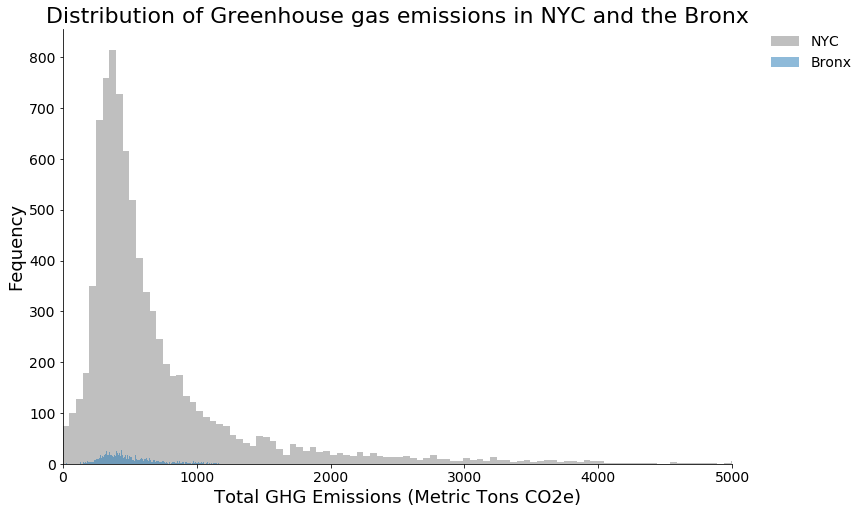

Just as the distribution of Site EUI looks different for the Bronx, so too does the distribution of Greenhouse Gass emissions. This is more reason to isolate the Bronx and only compare with appropriate peers.


In [99]:
# ghg
plt.hist(df['ghg'][df['ghg']<10000], bins=200, color = "Grey", label = "NYC", alpha=0.5)
plt.hist(df_bx['ghg'][df_bx['ghg']<10000], bins=200, label = "Bronx", alpha=0.5)
plt.title('Distribution of Greenhouse gas emissions in NYC and the Bronx')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Total GHG Emissions (Metric Tons CO2e)')
plt.xlim(0, 5000)
plt.ylabel('Fequency')
plt.show()
print ('Just as the distribution of Site EUI looks different for the Bronx, so too does the distribution of Greenhouse Gass emissions. This is more reason to isolate the Bronx and only compare with appropriate peers.')

In [55]:
# do these follow the same distribution? 
import scipy.stats
np.random.seed(14)

NY_sample_eui = np.random.choice(df.eui, size=1664, replace=False)

print (scipy.stats.ks_2samp(df_bx.eui, NY_sample_eui))
print ("We cannot reject the null that there's no statistical difference. These distributions are different. What's going on in the Bronx?")

Ks_2sampResult(statistic=0.11382009897681705, pvalue=6.9860559507570073e-10)
We cannot reject the null that there's no statistical difference. These distributions are different. What's going on in the Bronx?


In [56]:
# are the GHG emissions different in the bronx than the rest of nyc? 

NY_sample_ghg = np.random.choice(df.ghg, size=1664, replace=False)

print (scipy.stats.ks_2samp(df_bx.ghg, NY_sample_ghg))
print ("We cannot reject the null that there's no statistical difference. These distributions are different. What's going on in the Bronx?")

Ks_2sampResult(statistic=0.12680864578052264, pvalue=3.6539676171637896e-12)
We cannot reject the null that there's no statistical difference. These distributions are different. What's going on in the Bronx?


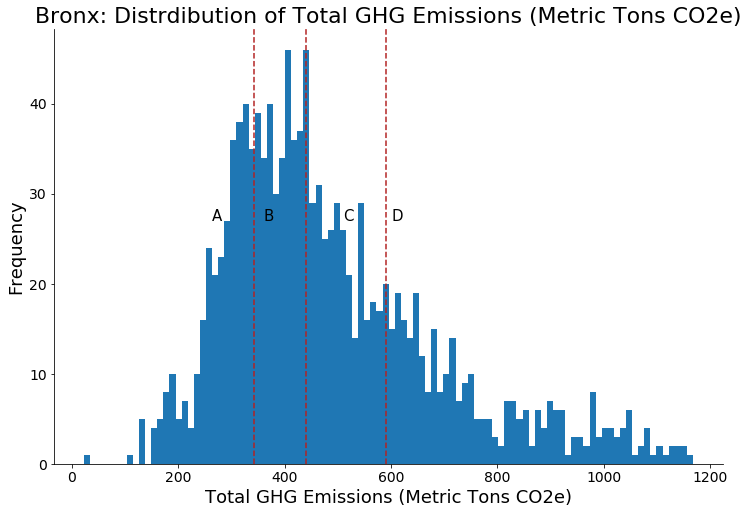

In [101]:
plt.hist(df_bx['ghg'], bins=100)
for label, pos in zip(['A', 'B', 'C'], df_bx['ghg'].describe()[4:7].values):
    plt.axvline(x=pos, color='firebrick', linestyle='--')
    plt.text(pos-80, 27, label, fontsize=15)
plt.text(pos+10, 27, 'D', fontsize=15)
plt.title('Bronx: Distrdibution of Total GHG Emissions (Metric Tons CO2e)')
plt.xlabel('Total GHG Emissions (Metric Tons CO2e)')
plt.ylabel('Frequency')
plt.show();

# Modeling

In [128]:
# predicting GHG from PLUTO inputs about buildings
lm = smf.ols(formula = 'ghg ~ floor_area', data = bx).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ghg   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.350
Method:                 Least Squares   F-statistic:                     185.0
Date:                Sun, 12 Nov 2017   Prob (F-statistic):           6.10e-34
Time:                        17:13:37   Log-Likelihood:                -2222.0
No. Observations:                 342   AIC:                             4448.
Df Residuals:                     340   BIC:                             4456.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    186.1117     24.182      7.696      0.000     138.547     233.676
floor_area     0.0038      0.000     13.601      0.000       0.003       0.004
==============================================================================
Omnibus:                       16.479   Durbin-Watson:                   1.844
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.472
Skew:                           0.531   Prob(JB):                     0.000161
Kurtosis:                       3.317   Cond. No.                     2.43e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.43e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [129]:
lm_y = lm.fittedvalues

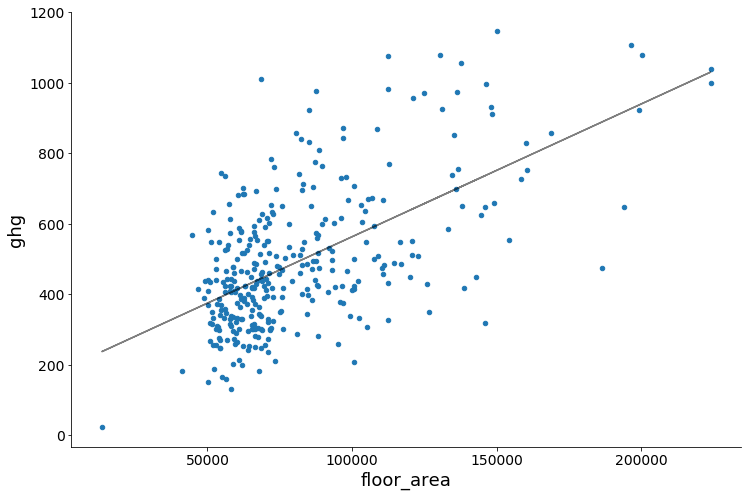

In [130]:
# adding more features only made the model slightly better, but risked overfitting. 

x = bx['floor_area']
# y = bx['ghg']

ax = bx.plot(x='floor_area', y='ghg', kind='scatter')
ax.plot(bx.floor_area, lm.fittedvalues, 'k', alpha=0.5)


In [131]:
# predicting GHG from PLUTO inputs about buildings
lm2 = smf.ols(formula = 'ghg ~ floor_area + ZipCode + NumFloors + LotArea +property_type', data = bx).fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ghg   R-squared:                       0.393
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                     54.43
Date:                Sun, 12 Nov 2017   Prob (F-statistic):           2.26e-35
Time:                        17:13:42   Log-Likelihood:                -2211.1
No. Observations:                 342   AIC:                             4432.
Df Residuals:                     337   BIC:                             4451.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.507e+04   1.42e+04     -1.059      0.290   -4.31e+04    1.29e+04
floor_area     0.0043      0.000     11.023      0.000       0.004       0.005
ZipCode        1.4706      1.360      1.081      0.280      -1.205       4.146
NumFloors    -27.7361      6.416     -4.323      0.000     -40.356     -15.116
LotArea        0.0006      0.002      0.422      0.673      -0.002       0.004
==============================================================================
Omnibus:                       14.231   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               14.828
Skew:                           0.480   Prob(JB):                     0.000603
Kurtosis:                       3.344   Cond. No.                     1.51e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
# compare each item to where that item falls on the fit line. make that proportion and map. '
# average of that per zip code

In [150]:
# adding column that compares the predicted y value for ghg with the actual ghg
bx['compare'] = bx.ghg/lm_y

In [179]:
bx_look = bx[['Zip', 'compare']]
bx_look.head()

,Zip,compare
2,10454.0,0.880828
5,10455.0,0.870956
10,10451.0,1.609460
12,10451.0,0.757311
13,10451.0,0.682658


In [180]:
bx_look['avg_proportion'] = bx.groupby('Zip')['compare'].transform('mean')
bx_look.head()


/Users/sebscho/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Zip,compare,avg_proportion
2,10454.0,0.880828,0.833078
5,10455.0,0.870956,0.895634
10,10451.0,1.609460,0.954066
12,10451.0,0.757311,0.954066
13,10451.0,0.682658,0.954066


In [178]:
bx_look.drop_duplicates(subset='Zip', keep=False)

# df.drop_duplicates(subset='A', keep="last")
bx_look.head()


,Zip,compare,count,avg_proportion
2,10454.0,0.880828,2.0,0.833078
5,10455.0,0.870956,9.0,0.895634
10,10451.0,1.609460,34.0,0.954066
12,10451.0,0.757311,34.0,0.954066
13,10451.0,0.682658,34.0,0.954066
